In [ ]:
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"CUDA version: {torch.version.cuda}")
device


Is CUDA supported by this system? True
CUDA version: 11.3


'cuda'

In [ ]:
train = pd.read_csv('/content/ECG200_TRAIN.tsv', header=None, delimiter='\t')
test = pd.read_csv('/content/ECG200_TEST.tsv', header=None, delimiter='\t')
# train = pd.read_csv('/content/ECG5000_TRAIN.tsv', header=None, delimiter='\t')
# test = pd.read_csv('/content/ECG5000_TEST.tsv', header=None, delimiter='\t')
# train = pd.read_csv('/content/DistalPhalanxTW_TRAIN.tsv', header=None, delimiter='\t')
# test = pd.read_csv('/content/DistalPhalanxTW_TEST.tsv', header=None, delimiter='\t')
# train = pd.read_csv('/content/Wafer_TRAIN.tsv', header=None, delimiter='\t')
# test = pd.read_csv('/content/Wafer_TEST.tsv', header=None, delimiter='\t')
print(np.unique(train[:][0]))
print(np.unique(test[:][0]))
train.head()


[-1  1]
[-1  1]


,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,-1,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,...,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,1,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,...,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,-1,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,...,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347
3,-1,1.168874,2.075901,1.760141,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,...,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540
4,1,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,...,-0.097869,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190


In [ ]:
train.shape, test.shape

((100, 97), (100, 97))

In [ ]:
X_train = torch.Tensor(train.to_numpy()[:,1:]).to(device)
X_test = torch.Tensor(test.to_numpy()[:,1:]).to(device)
# for Distal
# y_train = torch.Tensor(train.to_numpy()[:,0] - 3).to(device)
# y_test = torch.Tensor(test.to_numpy()[:,0] - 3).to(device)
# for ECG200 & Wafer
y_train = torch.Tensor((train.to_numpy()[:,0] + 1) // 2).to(device)
y_test = torch.Tensor((test.to_numpy()[:,0] + 1) // 2).to(device)
# for ECG5000
# y_train = torch.Tensor((train.to_numpy()[:,0] -1)).to(device)
# y_test = torch.Tensor((test.to_numpy()[:,0] - 1)).to(device)
torch.unique(y_train)

tensor([0., 1.], device='cuda:0')

In [ ]:

# generate a random hypervector of -1 and 1s
def generate_random_hypervector(dim):
    res = torch.randint(low=0, high=2, size=(dim,), device=device) # create random 0,1 vector
    res.mul_(2) # makes it 0,2 vector
    res.sub_(1) # makes it -1,1 vector
    return res

# generate a random hypermatrix of -1 and 1s
def generate_id_matrix(n_features=617, dim=1000):
    res = torch.randint(low=0, high=2, size=(n_features, dim), device=device) # create random 0,1 vector
    res.mul_(2) # makes it 0,2 vector
    res.sub_(1) # makes it -1,1 vector
    return res

class Encoder:
    def __init__(self, dim=1000, timestep=1, y_max=1, y_min=0, sensitivity=200):
        self.dim = dim
        self.y_max_hd = generate_random_hypervector(self.dim)
        # self.y_min_hd = generate_random_hypervector(self.dim)
        # self.y_max_hd = torch.ones(self.dim).to(device)
        self.y_min_hd = -1 * self.y_max_hd
        self.y_max = y_max
        self.y_min = y_min
        self.sensitivity = sensitivity
        self.gap = (y_max-y_min) / self.sensitivity
        meta = np.linspace(y_min, y_max, self.sensitivity)
        self.position_hds = generate_id_matrix(timestep, dim)
        self.quantized = torch.zeros((meta.shape[0], self.dim)).to(device)
        for i, val in enumerate(meta):
            self.quantized[i] = self.interpolate(val)
        # self.quantized = generate_id_matrix(self.sensitivity, dim)

    def interpolate(self, val):
        if val >= self.y_max:
            return torch.clone(self.y_max_hd)
        if val <= self.y_min:
            return torch.clone(self.y_min_hd)
        n_from_max = round((val.item() - self.y_min)/(self.y_max - self.y_min)*self.dim)
        # randomly choose "n_from_max" indices to copy from y_max_hd
        indices_from_max = np.random.choice(range(self.dim), size=n_from_max, replace=False)
        hd_vec = torch.clone(self.y_min_hd)
        hd_vec[indices_from_max] = self.y_max_hd[indices_from_max]
        return hd_vec

    def quantized_encode(self, val):
        if pd.isnull(val.item()):
          return self.quantized[self.sensitivity//2]
        ind = max(min(round((val.item() - self.y_min) / self.gap), self.sensitivity-1), 0)
        return self.quantized[ind]

In [ ]:
class intESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 noise=0.001, input_shift=None,
                 input_scaling=None, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 random_state=None, silent=True, clip=7, q_in=None):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            noise: noise added to each neuron (regularization)
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.noise = noise
        self.q_in = q_in
        
        self.silent = silent
        self.clip = clip

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.
        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        for j in range(input_pattern.shape[0]):
            state = (torch.roll(state,-1, dims=(0)) # shift state by 1
                            + self.q_in(input_pattern[j])
                            + output_pattern)
        t = state + self.noise * (torch.rand(self.n_reservoir).to(device) - 0.5)
        return torch.clip(t, -self.clip, self.clip)
        # return (t - t.min())/(t.max()-t.min()) * self.clip*2 - self.clip
        # return torch.tanh(t)

    def fit(self, inputs, outputs, outputs_hd, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.
        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states
        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = torch.reshape(inputs, (len(inputs), -1)).to(device)
        if outputs.ndim < 2:
            outputs = torch.reshape(outputs, (len(outputs), -1)).to(device)
        # transform input and teacher signal:
        encoded_outputs = outputs_hd

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = torch.zeros((inputs.shape[0], self.n_reservoir)).float().to(device)
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1,:], inputs[n, :],
                                        outputs_hd[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # extended_states = states
        # include the raw inputs:
        extended_states = torch.hstack((states, inputs)).float()

        # Solve for W_out:
        self.W_out = torch.matmul(torch.linalg.pinv(extended_states[transient:, :]).float(),
                            outputs[transient:, :].float()).T

        # remember the last state for later:
        self.laststate = states[-20:, :]
        self.lastinput = inputs[-20:, :]
        self.lastoutput = outputs_hd[-20, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = torch.matmul(extended_states, self.W_out.T)
        if not self.silent:
            print(torch.sqrt(torch.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=False):
        """
        Apply the learned weights to the network's reactions to new input.
        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state
        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = torch.reshape(inputs, (len(inputs), -1)).to(device)
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = torch.zeros((1,self.n_reservoir)).to(device)
            lastinput = torch.zeros((1,inputs.shape[1])).to(device)
            lastoutput = torch.zeros((1,self.n_reservoir)).to(device)

        inputs = torch.vstack([lastinput, inputs])
        states = torch.vstack(
            [laststate, torch.zeros((n_samples, self.n_reservoir)).to(device)])
        outputs = torch.zeros((states.shape[0], self.n_outputs)).to(device)
        outputs_encoded = torch.vstack([lastoutput, torch.zeros((n_samples, self.n_reservoir)).to(device)])
        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs_encoded[n, :])
            extended_states = torch.hstack((states[n+1, :], inputs[n+1, :])).float()
            # extended_states = states[n+1,:]
            outputs[n + 1, :] = torch.matmul(self.W_out, extended_states)
            outputs_encoded[n+1,:] = output_refs[outputs[n + 1, :].argmax()]

        return outputs[1:]

In [ ]:
n_classes = len(torch.unique(y_train))
y_train_onehot = torch.eye(n_classes)[y_train.long()].to(device)
dims = [50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 5000, 10000]
accuracies2 = torch.zeros(len(dims))
for ind, dim in enumerate(dims):
    for run in range(1):
        for sens in [200]:
          encoder = Encoder(dim=dim, y_max=X_train.max().item(), y_min=X_train.min().item(), sensitivity=sens)
          output_refs = generate_id_matrix(n_classes, dim) # generate hd for each class
          hd_y_train = output_refs[y_train.long()]

          esn = intESN(n_inputs=1, n_outputs=n_classes, n_reservoir=dim, clip=7, q_in=encoder.quantized_encode)
          esn.fit(X_train, y_train_onehot, hd_y_train)
          preds = esn.predict(X_test, continuation=False)
          preds = preds.argmax(dim=1)
          acc = torch.sum(preds == y_test).item()/preds.shape[0]
          accuracies2[ind] = max(accuracies2[ind], acc)
    print(dim, acc)

800 0.8372809863724854
900 0.6943543153796237
1000 0.72744970798183
2000 0.9511680726800779
5000 0.9621998702141467
10000 0.9651200519143414


In [ ]:
def permute(expanded,amount):
  return np.array(list(expanded)[amount:len(expanded)]+list(expanded)[0:amount])
  
def mse(prediction,data):
        return np.sqrt(np.mean((prediction - data)**2))

def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.
    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s
    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.
        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.
        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states
        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.
        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state
        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

In [ ]:
y_train_onehot = np.eye(n_classes)[y_train.long().cpu().numpy()]
dims = [50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 5000, 10000]
accuracies = np.zeros(len(dims))
for ind, dim in enumerate(dims):
    esn = ESN(n_inputs=X_train.shape[1], n_outputs=n_classes, n_reservoir=dim, random_state=42)
    esn.fit(X_train.cpu().numpy(), y_train_onehot)
    preds = esn.predict(X_test.cpu())
    preds = preds.argmax(axis=1)
    acc = np.sum(preds == y_test.cpu().numpy())/preds.shape[0]
    print(dim, acc)
    accuracies[ind] = acc

50 0.9235885788449059
75 0.9291044776119403
100 0.9407852044127191
200 0.9385139519792343
300 0.9333225178455549
400 0.9302401038286827
500 0.9231018818948734
600 0.9367293964957819
700 0.881570408825438
800 0.7822842310188189
900 0.7647631408176508
1000 0.8932511356262167
2000 0.9769630110317975
5000 0.9772874756651525
10000 0.9789097988319273


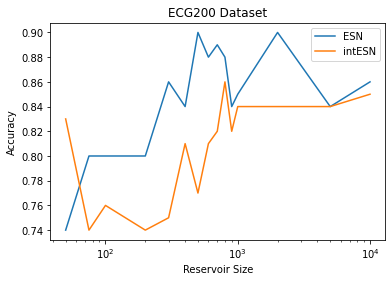

In [ ]:
plt.plot(dims, accuracies, label='ESN')
plt.plot(dims, acc, label='intESN')
plt.title('ECG200 Dataset')
plt.xlabel('Reservoir Size')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.legend()
plt.show()

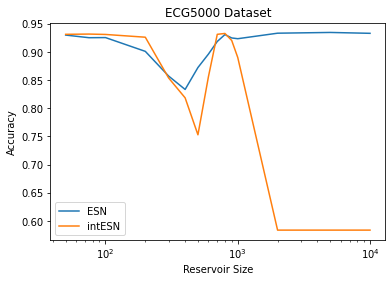

In [ ]:
plt.plot(dims, accuracies, label='ESN')
plt.plot(dims, accuracies2, label='intESN')
plt.title('ECG5000 Dataset')
plt.xlabel('Reservoir Size')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
accuracies2.max()

tensor(0.6691)

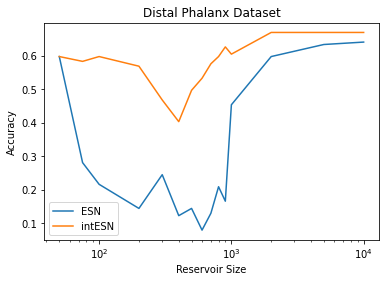

In [ ]:
plt.plot(dims, accuracies, label='ESN')
plt.plot(dims, accuracies2, label='intESN')
plt.title('Distal Phalanx Dataset')
plt.xlabel('Reservoir Size')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.legend()
plt.show()

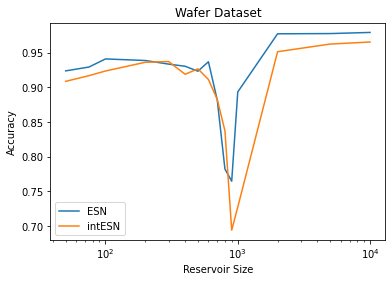

In [ ]:
plt.plot(dims, accuracies, label='ESN')
plt.plot(dims, acc, label='intESN')
plt.title('Wafer Dataset')
plt.xlabel('Reservoir Size')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
np.max(acc)

0.9651200771331787

# Time analysis

In [ ]:
import time
from tqdm import tqdm

n_classes = len(torch.unique(y_train))
dims = [50, 75, 100, 150, 200, 250, 300, 400, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000, 8000, 10000]
y_train_onehot = np.eye(n_classes)[y_train.long().cpu().numpy()]
times_reg = np.zeros((len(dims), 1))
for i, dim in tqdm(enumerate(dims)):
    start = time.time()
    esn = ESN(n_inputs=X_train.shape[1], n_outputs=n_classes, n_reservoir=dim, random_state=42)
    esn.fit(X_train.cpu().numpy(), y_train_onehot)
    preds = esn.predict(X_test.cpu())
    times_reg[i] = time.time() - start

times_int = np.zeros((len(dims), 1))
y_max = X_train.max().item()
y_min = X_train.min().item()
y_train_onehot = torch.eye(n_classes)[y_train.long()].to(device)
for i, dim in tqdm(enumerate(dims)):
    start = time.time()
    encoder = Encoder(dim=dim, y_max=y_max, y_min=y_min, sensitivity=200)
    output_refs = generate_id_matrix(n_classes, dim) # generate hd for each class
    hd_y_train = output_refs[y_train.long()]

    esn = intESN(n_inputs=1, n_outputs=n_classes, n_reservoir=dim, clip=7, q_in=encoder.quantized_encode)
    esn.fit(X_train, y_train_onehot, hd_y_train)
    preds = esn.predict(X_test, continuation=False)
    times_int[i] = time.time() - start

18it [11:10, 37.25s/it] 
18it [00:27,  1.51s/it]


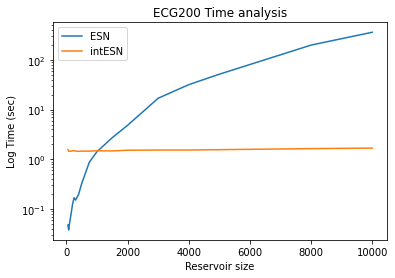

In [ ]:
plt.plot(dims, times_reg, label='ESN')
plt.plot(dims, times_int, label='intESN')
plt.xlabel('Reservoir size')
plt.ylabel('Log Time (sec)')
plt.legend()
plt.yscale('log')
# plt.xscale('log')
plt.title('ECG200 Time analysis')
plt.show()

25it [01:06,  2.68s/it]


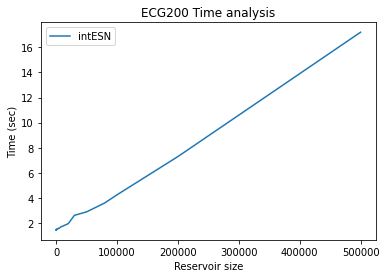

In [ ]:
dims = [50, 75, 100, 150, 200, 250, 300, 400, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000, 8000, 10000, 20000, 30000, 50000, 80000, 100000, 200000, 500000] #, 20000, 40000, 50000, 100000
times_int2 = np.zeros((len(dims), 1))
y_max = X_train.max().item()
y_min = X_train.min().item()
y_train_onehot = torch.eye(n_classes)[y_train.long()].to(device)
for i, dim in tqdm(enumerate(dims)):
    start = time.time()
    encoder = Encoder(dim=dim, y_max=y_max, y_min=y_min, sensitivity=200)
    output_refs = generate_id_matrix(n_classes, dim) # generate hd for each class
    hd_y_train = output_refs[y_train.long()]

    esn = intESN(n_inputs=1, n_outputs=n_classes, n_reservoir=dim, clip=7, q_in=encoder.quantized_encode)
    esn.fit(X_train, y_train_onehot, hd_y_train)
    preds = esn.predict(X_test, continuation=False)
    times_int2[i] = time.time() - start

plt.plot(dims, times_int2, label='intESN')
plt.title('ECG200 Time analysis')
plt.xlabel('Reservoir size')
plt.ylabel('Time (sec)')
plt.legend()
plt.show()